In [2]:
pip install pandas

In [3]:
pip install feather-format

  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2461 sha256=4e3d5b3d9bc11c11da925c71a4fc4226ca341e715640068b0d1e158ebd9bf02e
  Stored in directory: c:\users\91721\appdata\local\pip\cache\wheels\6e\3d\05\ebe8270ca366aa12810ee508ed4fac30d6343ac1584523f9ac
Successfully built feather-format
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install torch torchvision torchaudio

  Using cached torch-1.9.0-cp37-cp37m-win_amd64.whl (222.0 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an EnvironmentError: [Errno 28] No space left on device



In [1]:
from tqdm import tqdm
import os
import shutil
import numpy as np
import pandas as pd

import pylidc as pl

import feather
import png
from utils import *
#import utils-preprocessing

In [2]:
scans = pl.query(pl.Scan).all()
scans3 = scans[0:2]

In [3]:
scans[0].annotations

[Annotation(id=1,scan_id=1),
 Annotation(id=2,scan_id=1),
 Annotation(id=3,scan_id=1),
 Annotation(id=4,scan_id=1),
 Annotation(id=5,scan_id=1),
 Annotation(id=6,scan_id=1),
 Annotation(id=7,scan_id=1),
 Annotation(id=8,scan_id=1),
 Annotation(id=9,scan_id=1),
 Annotation(id=10,scan_id=1),
 Annotation(id=11,scan_id=1),
 Annotation(id=12,scan_id=1),
 Annotation(id=13,scan_id=1)]

In [4]:
annotation_df = flatten_annotations_by_nodule(scans)

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some n

In [6]:
annotation_df = annotation_df.assign(patient_number = annotation_df["patient_id"].str[-4:])
annotation_df = annotation_df.assign(nodule_idx = annotation_df[['patient_number','nodule_number']].apply(lambda x: str(x[0])+str("%02d" %x[1]),axis = 1))
feather.write_dataframe(annotation_df, os.path.join("resources","annotation_df.feather"))
annotation_df.to_csv(os.path.join("resources","annotation_df.csv"))

In [7]:
annotation_df = feather.read_dataframe(os.path.join("resources","annotation_df.feather"))

In [8]:
annotation_df = annotation_df.assign(malignancy = (annotation_df.malignancy -3)/2)

In [10]:
nodule_df = annotation_df.groupby(["nodule_idx","nodule_number","patient_id","scan_id","patient_number"], as_index = False).agg({
    'malignancy':['median','mean','min','max'],"annotation_id":'count'}).rename(columns={'annotation_id':'n_annotations'})
nodule_df = flatten_multiindex_columns(nodule_df)
nodule_df = nodule_df.assign(
    borderline = (np.sign(nodule_df.malignancy_min)== -np.sign(nodule_df.malignancy_max))| (np.abs(nodule_df.malignancy_mean)<=0.5/4)
    ,malignant = nodule_df.malignancy_mean > 0)

print(nodule_df.head())
print(nodule_df.shape)

print(nodule_df.pivot_table(values="nodule_idx",index = "borderline",columns="malignant",aggfunc='count',fill_value=0))

feather.write_dataframe(nodule_df,os.path.join("resources","nodule_df.feather"))
nodule_df.to_csv(os.path.join("resources","nodule_df.csv"))

  nodule_idx  nodule_number      patient_id scan_id patient_number  \
0     000101            1.0  LIDC-IDRI-0001      12           0001   
1     000201            1.0  LIDC-IDRI-0002      13           0002   
2     000301            1.0  LIDC-IDRI-0003      14           0003   
3     000302            2.0  LIDC-IDRI-0003      14           0003   
4     000303            3.0  LIDC-IDRI-0003      14           0003   

   malignancy_median  malignancy_mean  malignancy_min  malignancy_max  \
0               1.00            0.875             0.5             1.0   
1               0.75            0.750             0.5             1.0   
2              -0.50           -0.500            -0.5            -0.5   
3               0.75            0.625             0.0             1.0   
4               0.25            0.125            -0.5             0.5   

   n_annotations_count  borderline  malignant  
0                    4       False       True  
1                    2       False       Tru

In [11]:
nodule_df.head()

,nodule_idx,nodule_number,patient_id,scan_id,patient_number,malignancy_median,malignancy_mean,malignancy_min,malignancy_max,n_annotations_count,borderline,malignant
0,000101,1.0,LIDC-IDRI-0001,12,0001,1.00,0.875,0.5,1.0,4,False,True
1,000201,1.0,LIDC-IDRI-0002,13,0002,0.75,0.750,0.5,1.0,2,False,True
2,000301,1.0,LIDC-IDRI-0003,14,0003,-0.50,-0.500,-0.5,-0.5,1,False,False
3,000302,2.0,LIDC-IDRI-0003,14,0003,0.75,0.625,0.0,1.0,4,False,True
4,000303,3.0,LIDC-IDRI-0003,14,0003,0.25,0.125,-0.5,0.5,4,True,True


In [13]:
DATA_DIR = "H:/Project Data/manifest-1600709154662/data"
os.listdir(DATA_DIR)

[]

In [14]:
if not os.path.exists(os.path.join(DATA_DIR,"nodules-unsorted")):
    os.makedirs(os.path.join(DATA_DIR,"nodules-unsorted"))
    os.makedirs(os.path.join(DATA_DIR,"nodules2D","malignant"))
    os.makedirs(os.path.join(DATA_DIR,"nodules2D","benign"))
    os.makedirs(os.path.join(DATA_DIR,"nodules3D","malignant"))
    os.makedirs(os.path.join(DATA_DIR,"nodules3D","benign"))

In [15]:
np.random.seed(123456789)
resample_and_crop(scans, path = os.path.join(DATA_DIR,"nodules-unsorted"))

LIDC-IDRI-0078 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0069 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0079 nodule 1
LIDC-IDRI-0101 nodule 1
LIDC-IDRI-0110 nodule 1
 nodule 2
LIDC-IDRI-0115 nodule 1
LIDC-IDRI-0132 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
LIDC-IDRI-0136 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
LIDC-IDRI-0150 nodule 1
 nodule 2
LIDC-IDRI-0151 nodule 1
LIDC-IDRI-0154 nodule 1
 nodule 2
LIDC-IDRI-0001 nodule 1
LIDC-IDRI-0002 nodule 1
LIDC-IDRI-0003 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0004 nodule 1
LIDC-IDRI-0005 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0006 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0007 nodule 1
 nodule 2
LIDC-IDRI-0008 nodule 1
 nodule 2
LIDC-IDRI-0009 nodule 1
 nodule 2
LIDC-IDRI-0010 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0011 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
LIDC-IDRI-0012 nodule 1
 nodule 2
 nodule

 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
 nodule 11
LIDC-IDRI-0180 nodule 1
LIDC-IDRI-0181 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
LIDC-IDRI-0182 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0183 nodule 1
 nodule 2
LIDC-IDRI-0184 nodule 1
LIDC-IDRI-0185 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
LIDC-IDRI-0186 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
LIDC-IDRI-0187 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0188 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
LIDC-IDRI-0189LIDC-IDRI-0190 nodule 1
 nodule 2
LIDC-IDRI-0191 nodule 1
LIDC-IDRI-0192 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
LIDC-IDRI-0193 nodule 1
LIDC-IDRI-0194 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0195 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
LIDC-IDRI-0196 nodule 1
LIDC-IDRI-0197LIDC-IDRI-0198 nodule 1
LIDC-IDRI-0199 nodule 1
 nodule

 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
LIDC-IDRI-0391LIDC-IDRI-0392 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0393 nodule 1
LIDC-IDRI-0394 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
LIDC-IDRI-0395 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0396 nodule 1
 nodule 2
LIDC-IDRI-0397 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0398 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
 nodule 11
 nodule 12
 nodule 13
LIDC-IDRI-0399 nodule 1
 nodule 2
LIDC-IDRI-0400 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0401LIDC-IDRI-0402 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
LIDC-IDRI-0403 nodule 1
LIDC-IDRI-0404Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
LIDC-IDRI-0405 nodule 1
 nodule 2
 nodule 3
 nodule 4


 nodule 14
 nodule 15
 nodule 16
 nodule 17
 nodule 18
 nodule 19
 nodule 20
 nodule 21
 nodule 22
 nodule 23
LIDC-IDRI-0584 nodule 1
LIDC-IDRI-0586 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0587 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
LIDC-IDRI-0588 nodule 1
LIDC-IDRI-0589LIDC-IDRI-0590 nodule 1
LIDC-IDRI-0591 nodule 1
LIDC-IDRI-0592 nodule 1
 nodule 2
LIDC-IDRI-0593 nodule 1
LIDC-IDRI-0594 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0595 nodule 1
LIDC-IDRI-0596 nodule 1
 nodule 2
LIDC-IDRI-0597 nodule 1
LIDC-IDRI-0598 nodule 1
LIDC-IDRI-0599 nodule 1
 nodule 2
LIDC-IDRI-0600LIDC-IDRI-0601 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
LIDC-IDRI-0602 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0603LIDC-IDRI-0604 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
LIDC-IDRI-0605 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
LIDC-IDRI-0606 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0607 nodule 1
 nodule 2
LIDC-IDR

 nodule 1
 nodule 2
LIDC-IDRI-0862LIDC-IDRI-0861 nodule 1
 nodule 2
LIDC-IDRI-0860 nodule 1
 nodule 2
LIDC-IDRI-0859 nodule 1
LIDC-IDRI-0858 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
 nodule 11
 nodule 12
 nodule 13
LIDC-IDRI-0857 nodule 1
 nodule 2
LIDC-IDRI-0856 nodule 1
LIDC-IDRI-0855 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
 nodule 11
 nodule 12
 nodule 13
 nodule 14
 nodule 15
 nodule 16
LIDC-IDRI-0854 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
LIDC-IDRI-0853LIDC-IDRI-0852 nodule 1
 nodule 2
LIDC-IDRI-0851 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0850 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0849 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
LIDC-IDRI-0848 nodule 1
LIDC-IDRI-0847 nodule 1
LIDC-IDRI-0846 nodule 1
 nodule 2
LIDC-IDRI-0845 nodule 1
 nodule 2
LIDC-IDRI-0844 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0843 nodule 1

LIDC-IDRI-0668LIDC-IDRI-0667LIDC-IDRI-0666 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
LIDC-IDRI-0665LIDC-IDRI-0664 nodule 1
LIDC-IDRI-0663 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0662 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
LIDC-IDRI-0661 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
LIDC-IDRI-0660 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
LIDC-IDRI-0659 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
LIDC-IDRI-0658 nodule 1
LIDC-IDRI-0657 nodule 1
LIDC-IDRI-0656 nodule 1
 nodule 2
LIDC-IDRI-0655 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
LIDC-IDRI-0654 nodule 1
LIDC-IDRI-0653LIDC-IDRI-0652 nodule 1
 nodule 2
LIDC-IDRI-0651 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0650 nodule 1
LIDC-IDRI-0649 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
 nodule 11
LIDC-IDRI-0648 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0647 nodule 1
LIDC-IDRI-0646LIDC-I

In [17]:
malignant_idx = np.array(nodule_df.query('borderline == False & malignant == True').nodule_idx)
benign_idx = np.array(nodule_df.query('borderline == False & malignant == False').nodule_idx)
nodule_idx = np.array(nodule_df.query('borderline == False').nodule_idx)
print(malignant_idx.shape)
print(malignant_idx[:3])
print(benign_idx.shape)
print(nodule_idx.shape)

(427,)
['000101' '000201' '000302']
(1184,)
(1611,)


In [28]:
malignant_filenames = [str(x)+"_array.npy" for x in malignant_idx]
benign_filenames = [str(x)+"_array.npy" for x in benign_idx]
nodule_filenames = [str(x)+"_array.npy" for x in nodule_idx]
print(malignant_filenames[:3])

['000101_array.npy', '000201_array.npy', '000302_array.npy']


In [29]:
npy_dir = os.path.join(DATA_DIR,"nodules-unsorted")
sorted_dir = os.path.join(DATA_DIR,"nodules3D")
print(npy_dir)
print(sorted_dir)

H:/Project Data/manifest-1600709154662/data\nodules-unsorted
H:/Project Data/manifest-1600709154662/data\nodules3D


In [35]:
for i, file in enumerate(malignant_filenames):
    in_path  = os.path.join(npy_dir, file)
    out_path = os.path.join(sorted_dir, "malignant", str(malignant_idx[i])+".npy")
    try:
        shutil.copy(in_path, out_path)
    except FileNotFoundError:
        pass

In [37]:
for i, file in enumerate(benign_filenames):
    in_path = os.path.join(npy_dir,file)
    out_path = os.path.join(sorted_dir, "benign",str(benign_idx[i])+".npy")
    try:
        shutil.copy(in_path,out_path)
    except FileNotFoundError:
        pass

In [100]:
CUBE_DIR = os.path.join(DATA_DIR, "nodules-unsorted")
PNG_DIR = os.path.join(DATA_DIR, "nodules2D")

In [101]:
cubes = os.listdir(CUBE_DIR)

In [102]:
nod0 = np.load(os.path.join(CUBE_DIR,cubes[0]))

In [103]:
MIN_BOUND = -1000.0
MAX_BOUND = 600.0
PIXEL_MEAN = 0.25

def normalize(image):
    image = (image-MIN_BOUND)/(MAX_BOUND-MIN_BOUND)
    image[image>(1-PIXEL_MEAN)] = 1
    image[image<(0-PIXEL_MEAN)] = 0
    return np.array(255*image,dtype="uint8")

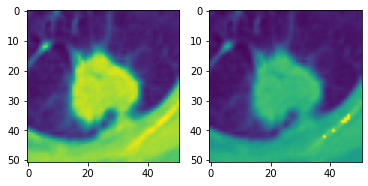

In [104]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.subplot(121)
plt.imshow(nod0[:,:,25])
plt.subplot(122)
plt.imshow(normalize(nod0[:,:,25]))
plt.show()

In [105]:
pngWriter = png.Writer(nod0.shape[0],nod0.shape[1], greyscale=1)

In [106]:
for i,cube in tqdm(enumerate(cubes)):
    try:
        nodule = np.load(os.path.join(CUBE_DIR,cube))
        mid_slice_id = np.int(nodule.shape[2]/2)
        mid_slice = nodule[:,:,mid_slice_id]
        mid_slice = normalize(mid_slice)
        fname = cube[:6]+".png"
        f = open(os.path.join(PNG_DIR,fname),"wb")
        pngWriter.write(f,mid_slice)
        f.close()
    except:
        print(str(cube)+" failed")

0it [00:00, ?it/s]D:\Anaconda\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
2627it [01:04, 40.96it/s]


D:\Anaconda\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current u

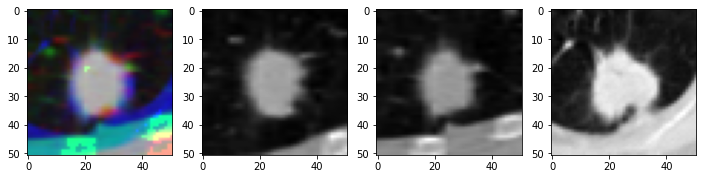

In [108]:
nod0.shape

def three_slice_rgb(x):
    dim = x.shape
    assert(np.unique(dim)).shape==(1,)
    dim = dim[0]
    
    rgb = np.zeros((dim,dim,3))
    
    rgb[:,:,0] = x[np.int(dim/2),:,:]
    rgb[:,:,1] = x[:,np.int(dim/2),:]
    rgb[:,:,2] = x[:,:,np.int(dim/2)]
    
    return rgb

def three_channel_plot(img, figsize=(12,6), titles=None):
    
    fig,axes = plt.subplots(1,4,figsize = figsize)
    
    axes[0].imshow(normalize(img))
    axes[1].imshow(img[:,:,0], cmap="gray")
    axes[2].imshow(img[:,:,1], cmap="gray")
    axes[3].imshow(img[:,:,2], cmap="gray")
    
three_channel_plot(three_slice_rgb((nod0)))

In [109]:
RGB_DIR = os.path.join(DATA_DIR, "nodulesRGB-unsorted")
if not os.path.exists(RGB_DIR):
    os.makedirs(RGB_DIR)
    
pngWriterRGB = png.Writer(nod0.shape[0],nod0.shape[1],greyscale = False)

In [110]:

for i, nod_id in enumerate(nodule_idx):
    try:
        nodule = np.load(os.path.join(CUBE_DIR, nod_id + str("_array.npy")))
        nodule_rgb = three_slice_rgb(nodule)
        nodule_rgb = normalize(nodule_rgb)
        img = png.from_array(nodule_rgb, mode = "RGB")
        img.save(os.path.join(RGB_DIR, nod_id + str(".png")))
    except:
        print(str(nod_id)+" failed")

D:\Anaconda\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current u

006102 failed
070302 failed
083401 failed


In [118]:

for i, nod_id in enumerate(malignant_idx):
    try:
        nodule = np.load(os.path.join(sorted_dir,"malignant", nod_id + str(".npy")))
        mid_slice_id = np.int(nodule.shape[2] / 2)
        mid_slice = normalize(nodule[:,:, mid_slice_id])
        f = open(os.path.join(PNG_DIR, "malignant", nod_id + str(".png")), "wb")
        pngWriter.write(f, mid_slice)
        f.close()
    except:
        print(str(nod_id)+" failed")

D:\Anaconda\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


070302 failed
083401 failed


In [119]:

for i, nod_id in enumerate(benign_idx):
    try:
        nodule = np.load(os.path.join(sorted_dir,"benign", nod_id + str(".npy")))
        mid_slice_id = np.int(nodule.shape[2] / 2)
        mid_slice = normalize(nodule[:,:, mid_slice_id])
        f = open(os.path.join(PNG_DIR, "benign", nod_id + str(".png")), "wb")
        pngWriter.write(f, mid_slice)
        f.close()
    except:
        print(str(nod_id)+" failed")

D:\Anaconda\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


006102 failed
